In [112]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from sklearn.model_selection import train_test_split
import io
from collections import Counter
import itertools
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import GRU,Bidirectional, Dense, Dropout, Reshape, Lambda, LSTM, RepeatVector, TimeDistributed
pd.options.mode.chained_assignment = None

In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
def read_csv(csv):
    raw_data = pd.read_csv('/content/drive/MyDrive/DeepLearn/datasets/'+csv, low_memory = False)
    shape = ",".join(map(str,raw_data.shape))
    s = 'dataframe shape of file' + csv + ' : ' + '('+ str(shape) +')'
    print(s)
    return raw_data

file_name = 'city_temperature.csv'
data = read_csv(file_name)

#print a dataframe
data.head()

dataframe shape of filecity_temperature.csv : (2906327,8)


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [128]:
ita_data = data.loc[data['Country'] == 'Italy']
ita_data["Time_steps"] = pd.to_datetime((ita_data.Year*10000 + ita_data.Month*100 + ita_data.Day).apply(str),format='%Y%m%d')
name_of_city = list(ita_data['City'].unique())
print('available cities: ', name_of_city)
#let's study the trend for Rome
rome_data = ita_data.loc[ita_data['City'] == name_of_city[1]]
print(rome_data)

available cities:  ['Milan', 'Rome']
        Region Country State  City  Month  Day  Year  AvgTemperature  \
803751  Europe   Italy   NaN  Rome      1    1  1995            58.3   
803752  Europe   Italy   NaN  Rome      1    2  1995            46.5   
803753  Europe   Italy   NaN  Rome      1    3  1995            41.6   
803754  Europe   Italy   NaN  Rome      1    4  1995            39.9   
803755  Europe   Italy   NaN  Rome      1    5  1995            37.0   
...        ...     ...   ...   ...    ...  ...   ...             ...   
813012  Europe   Italy   NaN  Rome      5    9  2020            61.8   
813013  Europe   Italy   NaN  Rome      5   10  2020            65.7   
813014  Europe   Italy   NaN  Rome      5   11  2020            65.6   
813015  Europe   Italy   NaN  Rome      5   12  2020            66.6   
813016  Europe   Italy   NaN  Rome      5   13  2020            60.2   

       Time_steps  
803751 1995-01-01  
803752 1995-01-02  
803753 1995-01-03  
803754 1995-01-04 

#Pre-Processing

In [129]:
#replace -99 values with NaN values
rome_data["AvgTemperature"] = np.where(rome_data["AvgTemperature"] == -99, np.nan, rome_data["AvgTemperature"])
rome_data.isnull().sum()

Region               0
Country              0
State             9266
City                 0
Month                0
Day                  0
Year                 0
AvgTemperature      29
Time_steps           0
dtype: int64

In [130]:
#the ffill() method replaces the NULL values with the value from the previous row (or previous column, if the axis parameter is set to 'columns' ).
rome_data["AvgTemperature"] = rome_data["AvgTemperature"].ffill()
rome_data.isnull().sum()

Region               0
Country              0
State             9266
City                 0
Month                0
Day                  0
Year                 0
AvgTemperature       0
Time_steps           0
dtype: int64

**Plot whole time series**

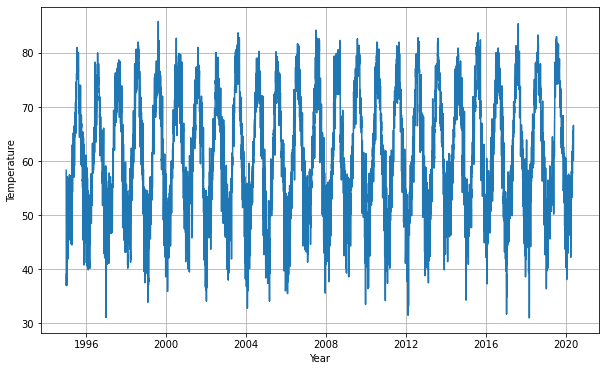

In [131]:
def plot_series(time, series, format="-", start=0, end=None):
    """to plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    plt.grid(True)

time_step = rome_data["Time_steps"].tolist()
temperature = rome_data["AvgTemperature"].tolist()
series = np.array(temperature)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

**Differencing**

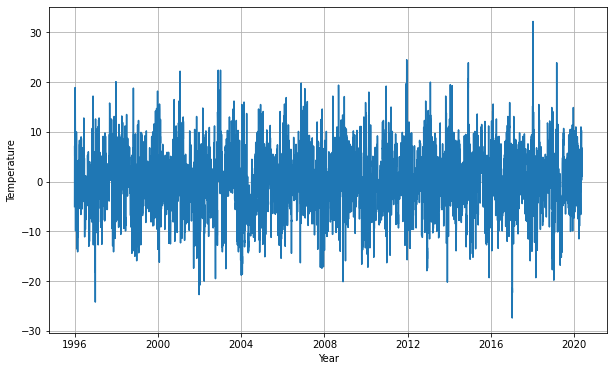

In [132]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]
plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

In [133]:
print('Differenced time series')
print('\n')
data = pd.DataFrame(diff_time, columns = ['Time_steps'])
data['AvgTemperature'] = diff_series
print(data)

Differenced time series


     Time_steps  AvgTemperature
0    1996-01-01            -5.0
1    1996-01-02             6.7
2    1996-01-03             7.2
3    1996-01-04             5.2
4    1996-01-05             8.4
...         ...             ...
8896 2020-05-09             2.3
8897 2020-05-10             5.1
8898 2020-05-11             5.2
8899 2020-05-12             6.8
8900 2020-05-13             1.1

[8901 rows x 2 columns]


**Moving Average**

In [134]:
rolling = data['AvgTemperature'].rolling(window=30)
data['AvgTemperature'] = rolling.mean()
data = data.dropna(axis=0)
print('Time series after moving average')
print('\n')
rome_data = data
rome_data.head()

Time series after moving average




,Time_steps,AvgTemperature
29,1996-01-30,5.280000
30,1996-01-31,5.303333
31,1996-02-01,5.160000
32,1996-02-02,5.200000
33,1996-02-03,5.360000


#Pre-Processing

**Split data**

In [136]:
#split 70,20,10
n = len(rome_data)
train_df = rome_data[0:int(n*0.7)]
val_df = rome_data[int(n*0.7):int(n*0.9)]
test_df = rome_data[int(n*0.9):]
print('Train Data shape: ', train_df.shape[0])
print('Val Data shape: ', val_df.shape[0])
print('Test Data shape: ', test_df.shape[0])

num_features = rome_data.shape[1]
print('n_features: ', num_features)

Train Data shape:  6210
Val Data shape:  1774
Test Data shape:  888
n_features:  2


**Normalization**

It is important to normalize the features before fed them to the network. 
However, it is important to notice that to perform this operation we can use only the mean and the standard deviation of the training set. To improve the result one could rely on moving average.

In [137]:
def normalization(train,val,test):
  scaler = MinMaxScaler(feature_range=(0, 1))
  #compute minimum and maximum used for scaling from training set
  scaler = scaler.fit(train)
  scaled_train = scaler.transform(train)
  # transform test
  scaled_val = scaler.transform(val)
  # transform test
  scaled_test = scaler.transform(test)
  return scaled_train,scaled_val,scaled_test

train_df[['AvgTemperature']], val_df[['AvgTemperature']], test_df[['AvgTemperature']] = normalization(train = train_df[['AvgTemperature']], val= val_df[['AvgTemperature']], test = test_df[['AvgTemperature']])


In [138]:
print('Train set normalized')
print('\n')
train_df.head()

Train set normalized




,Time_steps,AvgTemperature
29,1996-01-30,0.772450
30,1996-01-31,0.773670
31,1996-02-01,0.766173
32,1996-02-02,0.768265
33,1996-02-03,0.776635


**Plot training and test time series**

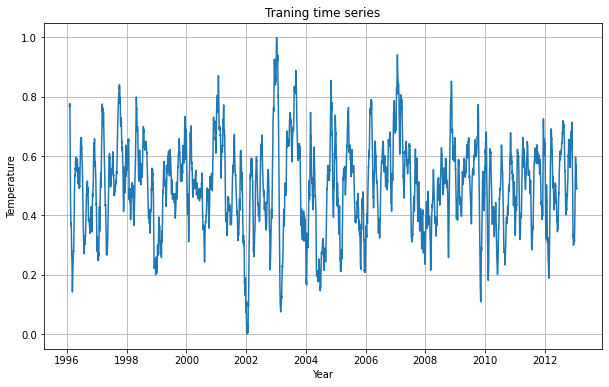

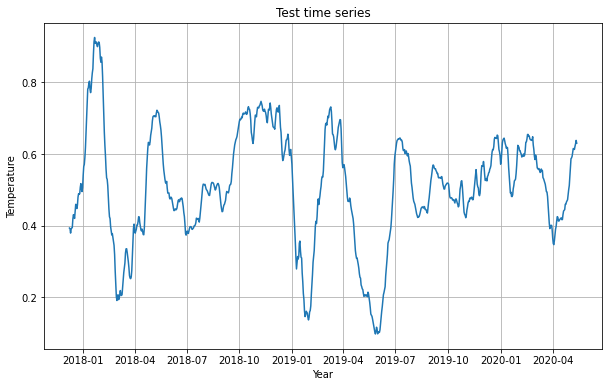

In [139]:
#get date and values of years
train_dates = train_df['Time_steps'].tolist()
train_temperatures = train_df['AvgTemperature'].tolist()
val_dates = val_df['Time_steps'].tolist()
val_temperatures = val_df['AvgTemperature'].tolist()
test_dates = test_df['Time_steps'].tolist()
test_temperatures = test_df['AvgTemperature'].tolist()

plt.figure(figsize=(10, 6))
plt.title('Traning time series')
#plot_series(train_dates, train_temperatures)
plot_series(train_dates, train_temperatures)
plt.show()
plt.figure(figsize=(10, 6))
plt.title('Test time series')
plot_series(test_dates, test_temperatures)
plt.show()

**Windowing**

In [140]:
def split_sequence(sequence, n_steps_in, n_steps_out):
  X = []
  y = []
  for i in range(len(sequence)):
    #where the input sequence ends
    end_idx = i + n_steps_in
    #where the output sequence ends
    out_end_idx = end_idx + n_steps_out
    # check if we are beyond the sequence
    if out_end_idx > len(sequence): break
    seq_x = np.array(sequence[i:end_idx])
    seq_y = sequence[end_idx:out_end_idx]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X),np.array(y)

#n_steps in: i.e. the length of the input sequence
#n_steps out: the length of the sequence in output (steps predicted)
n_steps_in = 30
n_steps_out = 30
#create train and test sets
X_train,y_train = split_sequence(train_temperatures, n_steps_in, n_steps_out)
X_val,y_val = split_sequence(val_temperatures, n_steps_in, n_steps_out)
X_test,y_test = split_sequence(test_temperatures, n_steps_in, n_steps_out)

print('total train sequences: ', len(X_train))
print('total val sequences: ', len(X_val))
print('total test sequences: ', len(X_test))

total train sequences:  6151
total val sequences:  1715
total test sequences:  829


**Plot slices in training set**

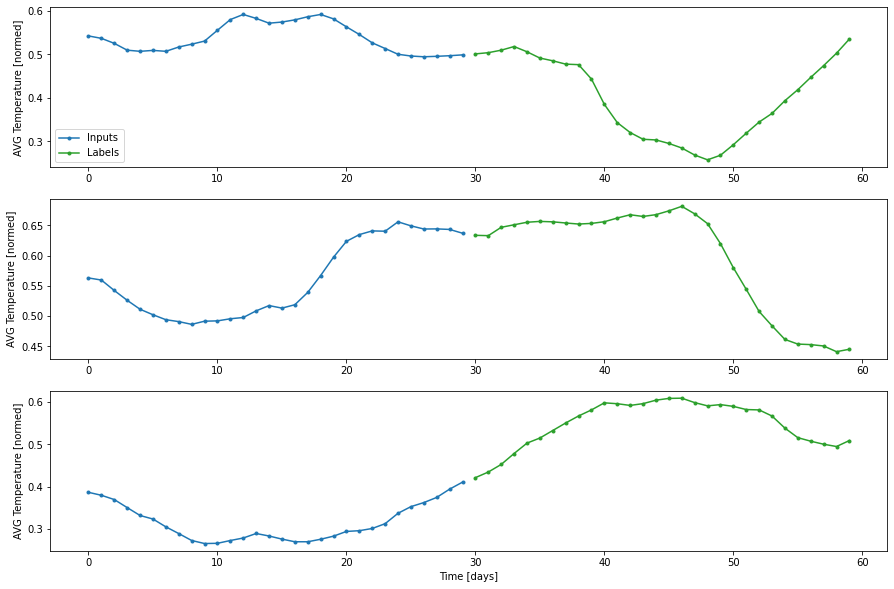

In [144]:
#plot some examples
def plot_time_series(inputs,labels,n_indices,model=None):
  plt.figure(figsize=(15, 10))
  list_idx = []
  for i in range(n_indices):
    list_idx.append(np.random.randint(len(inputs)))
  max_subplots = len(list_idx)
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    idx = list_idx[n]
    plt.subplot(max_n, 1, n+1)
    plt.ylabel('AVG Temperature [normed]')
    input_indices = [j for j in range(len(inputs[idx]))]
    plt.plot(input_indices, inputs[idx], label='Inputs', marker='.', zorder=-10)
    lab_indices = [k for k in range(len(inputs[idx]), len(inputs[idx])+ len(labels[idx]))]
    plt.plot(lab_indices,labels[idx], label='Labels', marker='.', c='#2ca02c')

    if model is not None:
      x = tf.expand_dims(inputs[idx], axis=0)
      preds = model(x)
      preds = np.squeeze(preds,axis=0)
      plt.plot(lab_indices,preds, label='Predictions', marker='.', c='#ff7f0e')
    if n == 0:
      plt.legend()
  
  plt.xlabel('Time [days]')

plot_time_series(X_train,y_train,n_indices=3,model=None)

#Model

In [145]:
#prepare 3D data for GRU (or LSTM)
def pre_data(x,n_features):
    X1 = x.reshape((x.shape[0], x.shape[1], n_features))
    return X1

n_features = 1
X_trainset= pre_data(X_train,n_features)
X_valset= pre_data(X_val,n_features)
X_testset= pre_data(X_test,n_features)

print('X_train shape: ', X_trainset.shape)
print('y_train shape: ', y_train.shape)

X_train shape:  (6151, 30, 1)
y_train shape:  (6151, 30)


In [51]:
#Model for single-step predictions
if n_steps_out == 1:
  gru_net = Sequential()
  gru_net.add(Bidirectional(GRU(16, activation='relu', return_sequences=False, input_shape=(n_steps_in,n_features))))
  gru_net.add(Dense(n_steps_out))

else:
  gru_net = Sequential()
  gru_net.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False, input_shape=(n_steps_in,n_features))))
  gru_net.add(Dense(16, activation='relu'))
  gru_net.add(Dense(n_steps_out))


lr = 0.0005
BATCH_SIZE = 32
optimizer = keras.optimizers.Adam(learning_rate=lr)

gru_net.compile(optimizer=optimizer, loss='mse', metrics= ['mae'])

In [52]:
gru_net.build(input_shape= (BATCH_SIZE, n_steps_in, 1))
print(gru_net.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (32, 64)                 8704      
 nal)                                                            
                                                                 
 dense_12 (Dense)            (32, 16)                  1040      
                                                                 
 dense_13 (Dense)            (32, 30)                  510       
                                                                 
Total params: 10,254
Trainable params: 10,254
Non-trainable params: 0
_________________________________________________________________
None


**Training**

In [53]:
EPOCHS = 100
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', min_delta=0.001, restore_best_weights=True)
history = gru_net.fit(X_trainset, y_train, batch_size=BATCH_SIZE, 
                      epochs=EPOCHS, verbose=1,
                      validation_data=(X_valset,y_val),
                      shuffle=False,
                      callbacks = [early_stop])


Epoch 1/100
193/193 [==============================] - 10s 29ms/step - loss: 0.1677 - mae: 0.3505 - val_loss: 0.0705 - val_mae: 0.1975
Epoch 2/100
193/193 [==============================] - 4s 21ms/step - loss: 0.0411 - mae: 0.1496 - val_loss: 0.0265 - val_mae: 0.1269
Epoch 3/100
193/193 [==============================] - 6s 31ms/step - loss: 0.0219 - mae: 0.1154 - val_loss: 0.0197 - val_mae: 0.1133
Epoch 4/100
193/193 [==============================] - 4s 23ms/step - loss: 0.0188 - mae: 0.1081 - val_loss: 0.0181 - val_mae: 0.1089
Epoch 5/100
193/193 [==============================] - 4s 21ms/step - loss: 0.0178 - mae: 0.1052 - val_loss: 0.0173 - val_mae: 0.1062
Epoch 6/100
193/193 [==============================] - 6s 33ms/step - loss: 0.0172 - mae: 0.1031 - val_loss: 0.0166 - val_mae: 0.1036
Epoch 7/100
193/193 [==============================] - 4s 21ms/step - loss: 0.0167 - mae: 0.1011 - val_loss: 0.0160 - val_mae: 0.1011
Epoch 8/100
193/193 [==============================] - 4s 22m

**Plot learning curves**

---------- CNN LEARNING CURVES ------------




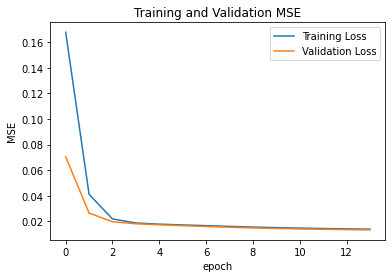

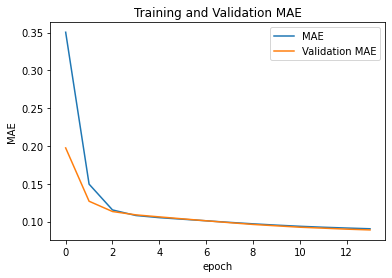

In [54]:
def learning_curves(history,epochs):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.plot(loss,label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('MSE')
  plt.title('Training and Validation MSE')
  plt.xlabel('epoch')
  plt.show()

  metric = history.history['mae']
  val_metric = history.history['val_mae']
  plt.plot(metric, label='MAE')
  plt.plot(val_metric,label='Validation MAE')
  plt.legend(loc='upper right')
  plt.ylabel('MAE')
  plt.title('Training and Validation MAE')
  plt.xlabel('epoch')
  plt.show()

print('---------- CNN LEARNING CURVES ------------')
print('\n')
learning_curves(history,EPOCHS)

**Testing**

In [55]:
results = gru_net.evaluate(X_testset,y_test, batch_size=BATCH_SIZE,verbose=1)
print("test loss, test mae:", results)

26/26 [==============================] - 0s 7ms/step - loss: 0.0158 - mae: 0.0941
test loss, test mae: [0.015753434970974922, 0.09407218545675278]


#Plot Single-Step Predictions

Single-step predictions based on 7 past days observation


28/28 [==============================] - 0s 3ms/step


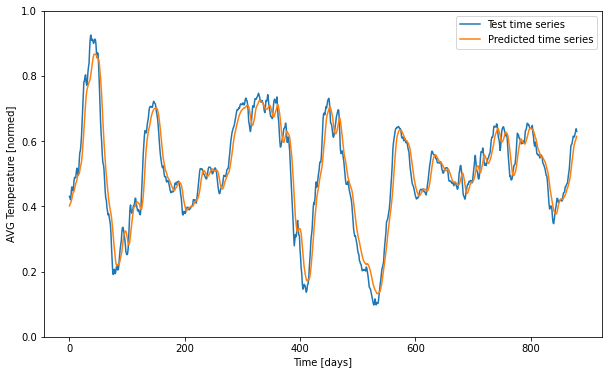

In [ ]:
#Model in single-step mode 
def plot_single_step_predictions(model,x_test,y_test):
  print(f'Single-step predictions based on {n_steps_in} past days observation')
  print('\n')
  preds = model.predict(X_testset, batch_size=BATCH_SIZE,verbose=1)
  plt.figure(figsize=(10, 6))
  plt.ylabel('AVG Temperature [normed]')
  plt.plot(y_test,label='Test time series')
  preds = np.squeeze(preds,axis=1)
  plt.plot(preds, label='Predicted time series')
  plt.ylim([0, 1])
  plt.legend()
  plt.xlabel('Time [days]')
  plt.show()

if n_steps_out == 1:
  plot_single_step_predictions(gru_net,x_test=X_testset,y_test=y_test)  

#Plot Multi-Step Predictions

**Plot slices of 30 days**

Multi-step predictions based on 30 past days observation to predict 30 future days observations




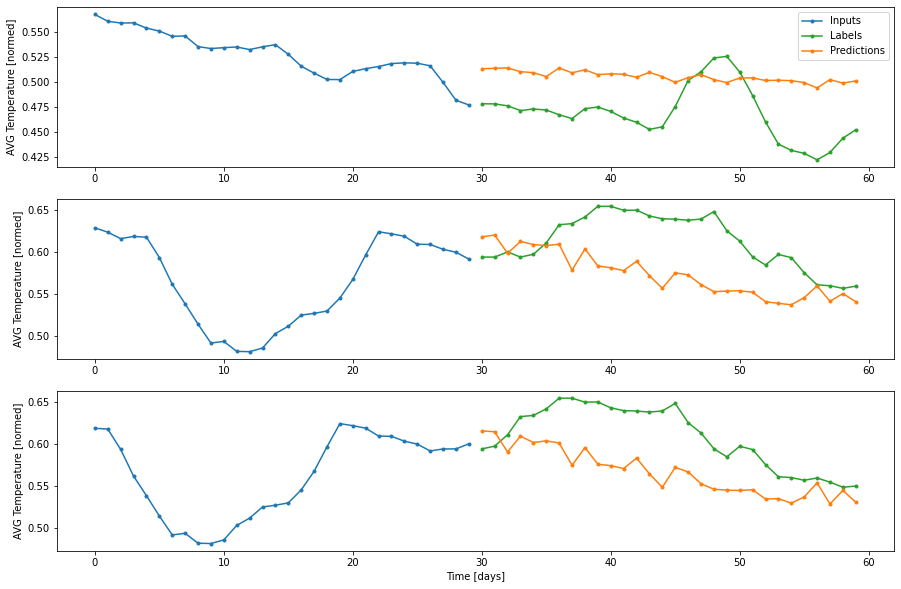

In [109]:
print(f'Multi-step predictions based on {n_steps_in} past days observation to predict {n_steps_out} future days observations')
print('\n')
plot_time_series(X_testset,y_test,n_indices=3,model=gru_net)

**Plot the whole predictions**

Multi-step predictions based on 30 past days observation to predict 30 future days observations


26/26 [==============================] - 0s 10ms/step


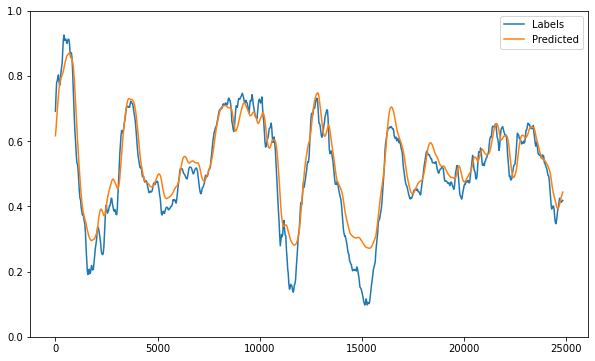

In [111]:
#plot the whole predictions
print(f'Multi-step predictions based on {n_steps_in} past days observation to predict {n_steps_out} future days observations')
print('\n')
preds = gru_net.predict(X_testset, batch_size=BATCH_SIZE,verbose=1)
#plot 
y_true = y_test.flatten()
y_preds = preds.flatten()
lab_ind = [n for n in range(len(y_true))]
plt.figure(figsize=(10, 6))
#plot every ith value using numpy's array slicing and indexing
plt.plot(lab_ind[::n_steps_out], y_true[::n_steps_out], label='Labels')
plt.plot(lab_ind[::n_steps_out], y_preds[::n_steps_out], label='Predicted')
plt.ylim([0, 1])
plt.legend()